# **Advances in Modeling High-Energy Astrophysical Sources:** 
## Insights from recent multimessenger discoveries 

### *Gammapy Hands-on: 3rd session*

*Disclaimer*:
The following tutorials are based almost completely on the those available at the [gammapy docs](https://docs.gammapy.org/dev/index.html). All credit of images, data, and other materials should go to the original authors. You will also find more information there that the one we can cover here. You might also want to have a look at this review on Gamma-Ray Data Analysis by [Denys Malyshev and Lars Mohrmann (2023)](https://arxiv.org/pdf/2309.02966).

In [9]:
# We will need another package for the session now
! conda config --add channels conda-forge
! conda install -y healpy

done
doneing environment: \ 


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 25.5.1

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=25.5.1



## Package Plan ##

  environment location: /home/willde/anaconda3/envs/gammapy-sexten

  added / updated specs:
    - healpy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    c-ares-1.34.5              |       hb9d3cd8_0         202 KB  conda-forge
    certifi-2025.6.15          |     pyhd8ed1ab_0         152 KB  conda-forge
    cfitsio-4.6.2              |       h44b4e7a_0         743 KB  conda-forge
    healpy-1.18.1              |  py312h78ed882_1         2.7 MB  conda-forge
    krb5-1.21.3                |       h659f571_0         1.3 MB  conda-forge
    libcurl-8.14.1   

#### **Fermi-LAT Analysis**

We will show you how to work with prepared Fermi-LAT data with Gammapy. As an example, we will look at the Galactic center region using the high-energy dataset that was used for the 3FHL catalog, in the energy range 10 GeV to 2 TeV.

It is important to note that LAT analysis with gammapy is limited, and by default it is better to employ the Fermi Science tools and Fermipy.

In order to be used in gammapy, the list of events from the Fermi Science Support Center is not enough, so you need at least to install the Fermi Science Tools, because you need to prepare beforehand ...

- A clean list of events (that is, use gtselect and gtmktime - an output of fermipy)
- The exposure cube (that is, the output of gtexpcube2 - also an output of fermipy -> this takes time)
- The PSF file (using gtpsf, **not an output of fermipy, you need the Fermi Science Tools**)



In [1]:
### Setup 
from astropy import units as u
from astropy.coordinates import SkyCoord

# %matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
from gammapy.data import EventList
from gammapy.datasets import Datasets, MapDataset
from gammapy.irf import EDispKernelMap, PSFMap
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Models,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    PowerLawSpectralModel,
    SkyModel,
    TemplateSpatialModel,
    create_fermi_isotropic_diffuse_model,
)


In [2]:
from gammapy.utils.check import check_tutorials_setup

check_tutorials_setup()


System:

	python_executable      : /home/willde/anaconda3/envs/gammapy-sexten/bin/python 
	python_version         : 3.12.11    
	machine                : x86_64     
	system                 : Linux      


Gammapy package:

	version                : 1.3        
	path                   : /home/willde/anaconda3/envs/gammapy-sexten/lib/python3.12/site-packages/gammapy 


Other packages:

	numpy                  : 2.3.0      
	scipy                  : 1.16.0     
	astropy                : 7.1.0      
	regions                : 0.10       
	click                  : 8.2.1      
	yaml                   : 6.0.2      
	IPython                : 9.1.0      
	jupyterlab             : 4.3.4      
	matplotlib             : 3.10.3     
	pandas                 : not installed 
	healpy                 : 1.18.1     
	iminuit                : 2.31.1     
	sherpa                 : not installed 
	naima                  : not installed 
	emcee                  : not installed 
	corner                 : not

Now, we create a config file for our analysis.
Why creating a YAML config file? 

-> Simple: it may be easier to handle and keep things under control (in gammapy frequently mentioned as "high level interface"). What we did on Tuesday was using the "low level interface".

Basically what we will do is:

Create an AnalysisConfig object and edit it to define the analysis configuration:

    - Define what observations to use

    - Define the geometry of the dataset (data and IRFs)

    - Define the model we want to fit on the dataset.

Instantiate a Analysis from this configuration and run the different analysis steps

    - Observation selection

    - Data reduction
    

In [3]:
# Let load the list of events already filtered with gtselect and gtmktime

events = EventList.read("$GAMMAPY_DATA/fermi_3fhl/fermi_3fhl_events_selected.fits.gz")
print(events)


EventList
---------

  Instrument       : LAT
  Telescope        : GLAST
  Obs. ID          : 

  Number of events : 697317
  Event rate       : 0.003 1 / s

  Time start       : 54682.65603222222
  Time stop        : 57236.96833546296

  Min. energy      : 1.00e+04 MeV
  Max. energy      : 2.00e+06 MeV
  Median energy    : 1.59e+04 MeV




In [4]:
# We have all the usual information
print(events.table.colnames)

display(events.table[:5][["ENERGY", "RA", "DEC"]])

print(events.time[0].iso)
print(events.time[-1].iso)

# Naturaly we can check the information relevant for us
energy = events.energy
energy.info("stats")

['ENERGY', 'RA', 'DEC', 'L', 'B', 'THETA', 'PHI', 'ZENITH_ANGLE', 'EARTH_AZIMUTH_ANGLE', 'TIME', 'EVENT_ID', 'RUN_ID', 'RECON_VERSION', 'CALIB_VERSION', 'EVENT_CLASS', 'EVENT_TYPE', 'CONVERSION_TYPE', 'LIVETIME', 'DIFRSP0', 'DIFRSP1', 'DIFRSP2', 'DIFRSP3', 'DIFRSP4']


<Table length=5>
  ENERGY       RA       DEC   
   MeV        deg       deg   
 float32    float32   float32 
---------- --------- ---------
12856.5205 139.64438  -9.93702
 14773.319 177.04454  60.55275
 23273.527 110.21325 37.002018
 41866.125 334.85287 17.577398
 42463.074 316.86676 48.152477

2008-08-04 15:49:26.782
2015-07-30 11:00:41.226
name = ENERGY
mean = 28905.5 MeV
std = 61051.7 MeV
min = 10000 MeV
max = 1.99848e+06 MeV
n_bad = 0
length = 697317


Let us start to prepare things for an 3D map analysis of the Galactic center region with Gammapy. The first thing we do is to define the map geometry. We chose a TAN projection centered on position (glon, glat) = (0, 0) with pixel size 0.1 deg, and four energy bins.

MapAxis

	name       : energy    
	unit       : 'MeV'     
	nbins      : 4         
	node type  : edges     
	edges min  : 1.0e+04 MeV
	edges max  : 2.0e+06 MeV
	interp     : log       



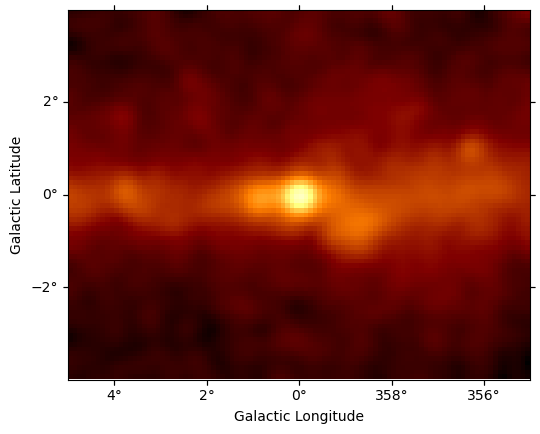

In [5]:
gc_pos = SkyCoord(0, 0, unit="deg", frame="galactic")
energy_axis = MapAxis.from_edges(
    [1e4, 3e4, 1e5, 3e5, 2e6], name="energy", unit="MeV", interp="log"
)
counts = Map.create(
    skydir=gc_pos,
    npix=(100, 80),
    proj="TAN",
    frame="galactic",
    binsz=0.1,
    axes=[energy_axis],
    dtype=float,
)
# We put this call into the same Jupyter cell as the Map.create
# because otherwise we could accidentally fill the counts
# multiple times when executing the `fill_by_coord` multiple times.
counts.fill_events(events)

print(counts.geom.axes[0])

counts.sum_over_axes().smooth(2).plot(stretch="sqrt", vmax=30)
plt.show()


The Fermi-LAT dataset in this tutorial contains the energy-dependent exposure for the whole sky as a HEALPix map computed with gtexpcube2 (which is not necessarily true of your own analysis of a region).

HpxGeom

	axes       : ['skycoord', 'energy_true']
	shape      : (np.int64(49152), 18)
	ndim       : 3
	nside      : 64
	nested     : False
	frame      : icrs
	projection : HPX
	center     : 0.0 deg, 0.0 deg

MapAxis

	name       : energy_true
	unit       : 'MeV'     
	nbins      : 18        
	node type  : center    
	center min : 1.0e+04 MeV
	center max : 2.0e+06 MeV
	interp     : log       



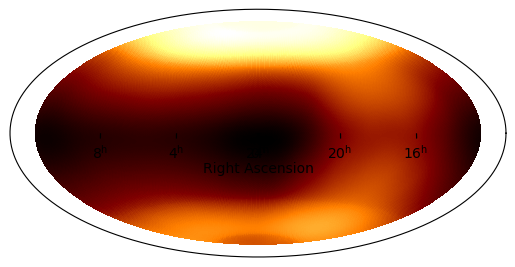

In [6]:
exposure_hpx = Map.read("$GAMMAPY_DATA/fermi_3fhl/fermi_3fhl_exposure_cube_hpx.fits.gz")
print(exposure_hpx.geom)
print(exposure_hpx.geom.axes[0])

exposure_hpx.plot()
plt.show()

What we need now is to match it with the binning we defined above. Interpolating the exposure cube from the Fermi Science Tools to get an exposure cube matching that is easy. The only point to watch out for is how exactly you want the energy axis and binning handled.

Below we just use the default behaviour, which is linear interpolation in energy on the original exposure cube. Probably log interpolation would be better, but it doesn’t matter much here, because the energy binning is small enough.

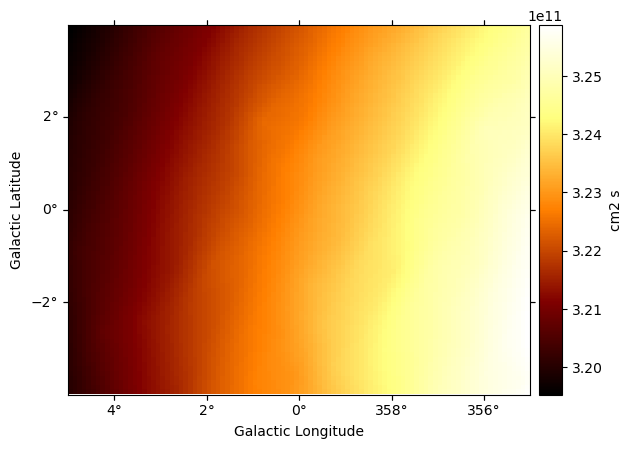

In [7]:
axis = MapAxis.from_energy_bounds(
    "10 GeV",
    "2 TeV",
    nbin=10,
    per_decade=True,
    name="energy_true",
)
geom = WcsGeom(wcs=counts.geom.wcs, npix=counts.geom.npix, axes=[axis])

exposure = exposure_hpx.interp_to_geom(geom)

# And we can see how it looks like in our region
exposure.slice_by_idx({"energy_true": 0}).plot(add_cbar=True)
plt.show()

# Note that although variations appear huge, the exposure is almost uniform


In a Fermi analysis is always very important to consider the Galactic diffuse emission. We already did that before! So we know how to handle this

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy_true']
	shape : (np.int64(120), np.int64(64), 30)
	ndim  : 3
	unit  : 1 / (MeV s sr cm2)
	dtype : >f4



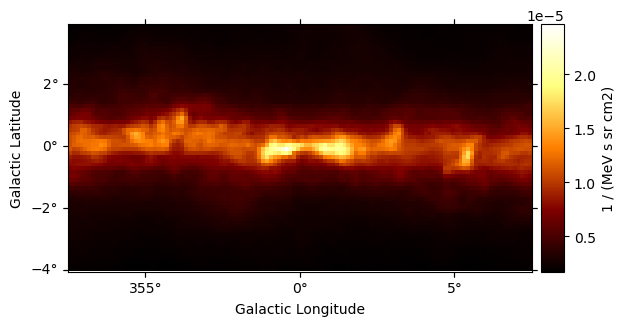

In [8]:
template_diffuse = TemplateSpatialModel.read(
    filename="$GAMMAPY_DATA/fermi-3fhl-gc/gll_iem_v06_gc.fits.gz", normalize=False
)

print(template_diffuse.map)

diffuse_iem = SkyModel(
    spectral_model=PowerLawNormSpectralModel(),
    spatial_model=template_diffuse,
    name="diffuse-iem",
)

template_diffuse.map.slice_by_idx({"energy_true": 0}).plot(add_cbar=True)
plt.show()



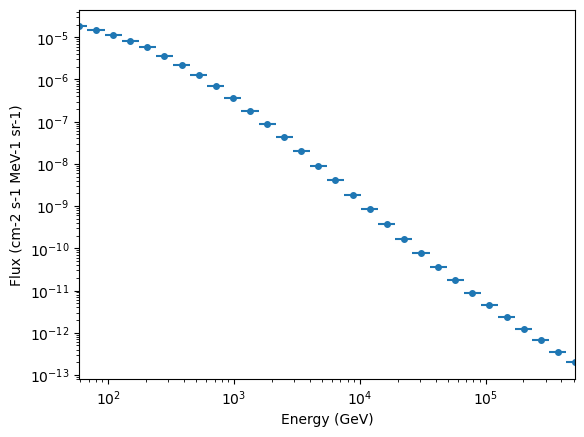

In [9]:
dnde = template_diffuse.map.to_region_nd_map(region=gc_pos)
dnde.plot()
plt.xlabel("Energy (GeV)")
plt.ylabel("Flux (cm-2 s-1 MeV-1 sr-1)")
plt.show()


In IACTs' analysis we had this FoV Background, or we used reflected or ring regions to get rid of the noise from hadronic and electron cascades that passed previous filters. The equivalent in Fermi would be the isotropic diffuse emission, which is a mixture of extragalactic diffuse events, missidentified CRs, spurious signals, ...

In [10]:
filename = "$GAMMAPY_DATA/fermi_3fhl/iso_P8R2_SOURCE_V6_v06.txt"

diffuse_iso = create_fermi_isotropic_diffuse_model(
    filename=filename, interp_kwargs={"extrapolate": True} # We extrapolate beyond the maximum energy tabulated in the file
)


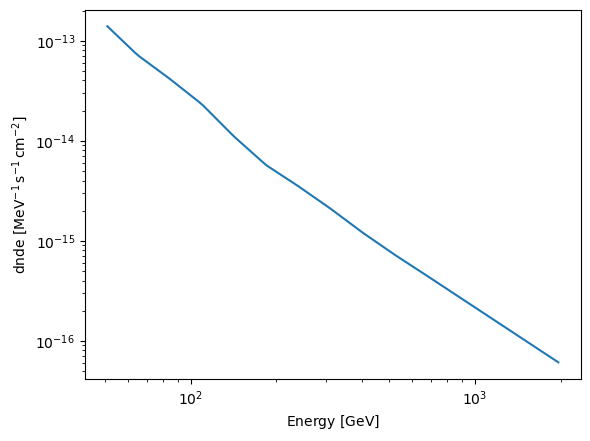

In [11]:
energy_bounds = [50, 2000] * u.GeV
diffuse_iso.spectral_model.plot(energy_bounds, yunits=u.Unit("1 / (cm2 MeV s)"))
plt.show()


So the last element missing is the PSF!

In [12]:
psf = PSFMap.read("$GAMMAPY_DATA/fermi_3fhl/fermi_3fhl_psf_gc.fits.gz", format="gtpsf")
print(psf)

RegionNDMap

	geom  : RegionGeom 
 	axes  : ['lon', 'lat', 'rad', 'energy_true']
	shape : (1, 1, 300, 17)
	ndim  : 4
	unit  : 1 / sr
	dtype : >f8



/home/willde/anaconda3/envs/gammapy-sexten/lib/python3.12/site-packages/gammapy/irf/psf/map.py:517: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(energy_true, radius, label=label, **kwargs)


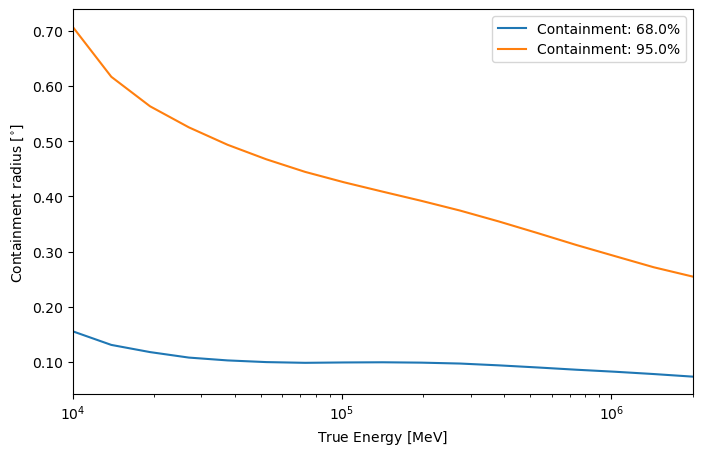

In [13]:
plt.figure(figsize=(8, 5))
psf.plot_containment_radius_vs_energy()
plt.show()

# Be aware that if you applied a cut on the PSF type of the events, you should prepare the exposure and this file accordingly!

/home/willde/anaconda3/envs/gammapy-sexten/lib/python3.12/site-packages/gammapy/irf/psf/map.py:563: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(rad, psf_value, label=label, **kwargs)
/home/willde/anaconda3/envs/gammapy-sexten/lib/python3.12/site-packages/gammapy/irf/psf/map.py:563: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(rad, psf_value, label=label, **kwargs)


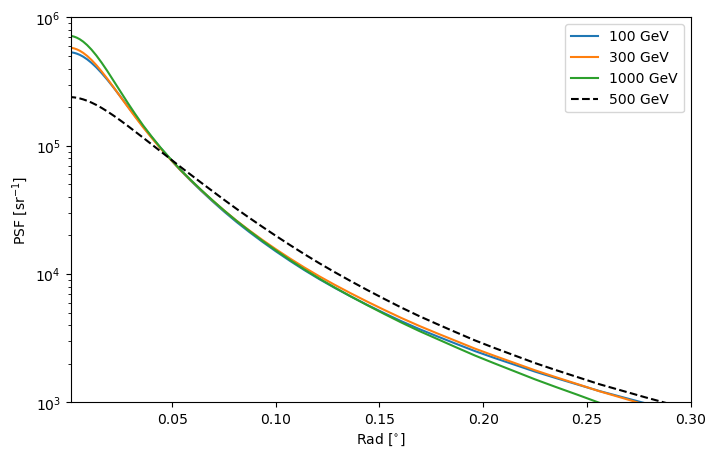

In [14]:
# Or we can compare them by energy
plt.figure(figsize=(8, 5))

energy = [100, 300, 1000] * u.GeV
psf.plot_psf_vs_rad(energy_true=energy)

spectrum = PowerLawSpectralModel(index=2.3)
psf_mean = psf.to_image(spectral_model=spectrum)
psf_mean.plot_psf_vs_rad(c="k", ls="--", energy_true=[500] * u.GeV)

plt.xlim(1e-3, 0.3)
plt.ylim(1e3, 1e6)
plt.legend()
plt.show()


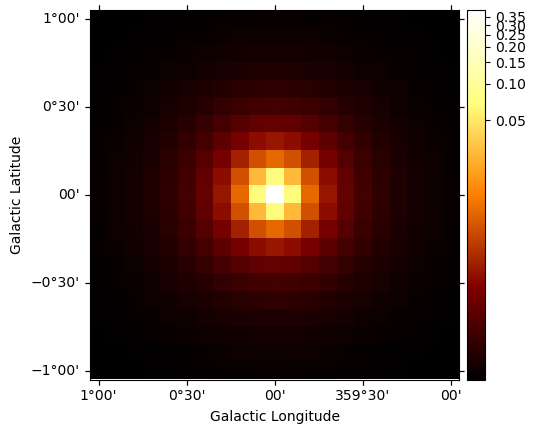

In [15]:
# And see how it looks in the map
psf_kernel = psf.get_psf_kernel(
    position=geom.center_skydir, geom=geom, max_radius="1 deg"
)
psf_kernel.to_image().psf_kernel_map.plot(stretch="log", add_cbar=True)
plt.show()

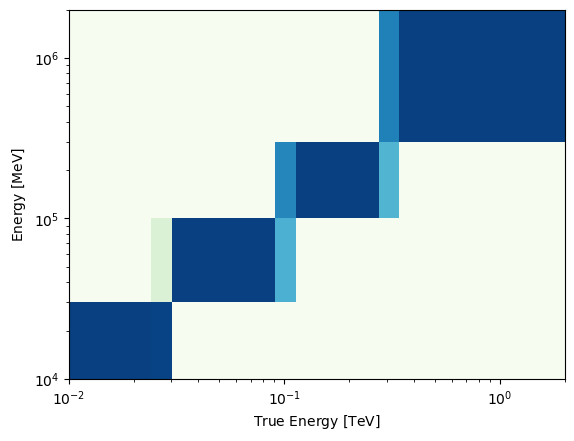

In [16]:
# For the energy dispersion, we assume it to be diagonal 
# For the LAT is almost irrelevant above 1 GeV anyway

e_true = exposure.geom.axes["energy_true"]
edisp = EDispKernelMap.from_diagonal_response(
    energy_axis_true=e_true, energy_axis=energy_axis
)

edisp.get_edisp_kernel().plot_matrix()
plt.show()


And finally we are ready for the analysis


In [17]:
# We create the sky model and load it into our dataset
spatial_model = PointSpatialModel(lon_0="0 deg", lat_0="0 deg", frame="galactic")
spectral_model = PowerLawSpectralModel(
    index=2.7, amplitude="5.8e-10 cm-2 s-1 TeV-1", reference="100 GeV"
)

source = SkyModel(
    spectral_model=spectral_model,
    spatial_model=spatial_model,
    name="source-gc",
)

# We add the Galactic center, the Galactic diffuse and the isotropic diffuse
models = Models([source, diffuse_iem, diffuse_iso])

dataset = MapDataset(
    models=models,
    counts=counts,
    exposure=exposure,
    psf=psf,
    edisp=edisp,
    name="fermi-dataset",
)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 197
	total stat : 19644.61

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

Models

Component 0: SkyModel

  Name                      : source-gc
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.754   +/-    0.12             
    amplitude                     :   5.28e-10   +/- 1.1e-10 1 / (TeV s cm2)
    reference             (frozen):    100.000       GeV         
    lon_0                         :     -0.025   +/-    0.00 deg         
    lat_0                         :     -0.041   +/-    0.00 deg         

Component 1: SkyModel

  Name                      : diffuse-iem
  Datasets names       

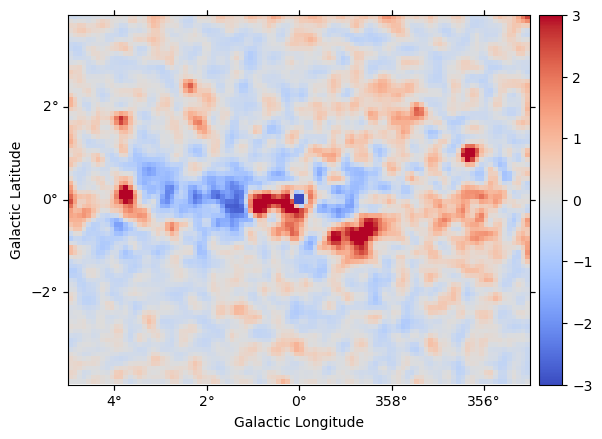

In [18]:
fit = Fit()
result = fit.run(datasets=[dataset])

print(result)

print(models)

residual = counts - dataset.npred()

residual.sum_over_axes().smooth("0.1 deg").plot(
    cmap="coolwarm", vmin=-3, vmax=3, add_cbar=True
)
plt.show()

*Question: This looks terrible! Why?*

#### **HAWC analysis**

Quick introduction to HAWC data analysis with Gammapy. It briefly describes the HAWC data and how to access it, and then uses a subset of the data to produce a MapDataset, to show how the data reduction is performed. We will use a subset of the public Crab dataset released by the HAWC team.

The HAWC data release contains events where the energy is estimated using two different algorithms, referred to as “NN” (neural network) and “GP” (ground parameter). For more details, you can have a look at [this paper](https://iopscience.iop.org/article/10.3847/1538-4357/ab2f7d/pdf). These two event classes are not independent, meaning that events are repeated between the NN and GP datasets. Therefore, these data should never be analysed jointly, and one of the two estimators needs to be chosen before proceeding.

Once the data has been reduced to a MapDataset, there are no differences in the way that HAWC data is handled with respect to data from any other observatory, such as H.E.S.S. or CTAO.

In [19]:
#Setup
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
from gammapy.data import DataStore, HDUIndexTable, ObservationTable
from gammapy.datasets import MapDataset
from gammapy.estimators import ExcessMapEstimator
from gammapy.estimators import LightCurveEstimator
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.maps import Map, MapAxis, WcsGeom


In [20]:
from gammapy.utils.check import check_tutorials_setup

check_tutorials_setup()


System:

	python_executable      : /home/willde/anaconda3/envs/gammapy-sexten/bin/python 
	python_version         : 3.12.11    
	machine                : x86_64     
	system                 : Linux      


Gammapy package:

	version                : 1.3        
	path                   : /home/willde/anaconda3/envs/gammapy-sexten/lib/python3.12/site-packages/gammapy 


Other packages:

	numpy                  : 2.3.0      
	scipy                  : 1.16.0     
	astropy                : 7.1.0      
	regions                : 0.10       
	click                  : 8.2.1      
	yaml                   : 6.0.2      
	IPython                : 9.1.0      
	jupyterlab             : 4.3.4      
	matplotlib             : 3.10.3     
	pandas                 : not installed 
	healpy                 : 1.18.1     
	iminuit                : 2.31.1     
	sherpa                 : not installed 
	naima                  : not installed 
	emcee                  : not installed 
	corner                 : not

In [21]:
# We will do our analysis using the NN estimator
energy_estimator = "NN"

In [22]:
# Hawc data is typically loaded to a table
data_path = "$GAMMAPY_DATA/hawc/crab_events_pass4/"
hdu_filename = f"hdu-index-table-{energy_estimator}-Crab.fits.gz"
obs_filename = f"obs-index-table-{energy_estimator}-Crab.fits.gz"

obs_table = ObservationTable.read(data_path + obs_filename)

The HAWC data is divided into different event types, classified using the fraction of the array that was triggered by an event, a quantity usually referred to as “fHit” (representd as integers from 1 to 9). These event types are fully independent, meaning that an event will have a unique event type identifier, which is usually a number indicating which fHit bin the event corresponds to.

In this tutorial we will only use fHit value, however, for a regular analysis you should combine all fHit bins. Here, we utilise fHit bin number 6. We start by reading the HDU index table of this fHit bin.

In [23]:
fHit = 6
hdu_table = HDUIndexTable.read(data_path + hdu_filename, hdu=fHit)

# And we create the DataStore
data_store = DataStore(hdu_table=hdu_table, obs_table=obs_table)

data_store.info()


Data store:
HDU index table:
BASE_DIR: /home/willde/Programes/gammapy-datasets/1.0.1/hawc/crab_events_pass4
Rows: 6
OBS_ID: 103000133 -- 103000133
HDU_TYPE: [np.str_('aeff'), np.str_('bkg'), np.str_('edisp'), np.str_('events'), np.str_('gti'), np.str_('psf')]
HDU_CLASS: [np.str_('edisp_kernel_map'), np.str_('events'), np.str_('gti'), np.str_('map'), np.str_('psf_map_reco')]


Observation table:
Observatory name: 'N/A'
Number of observations: 1



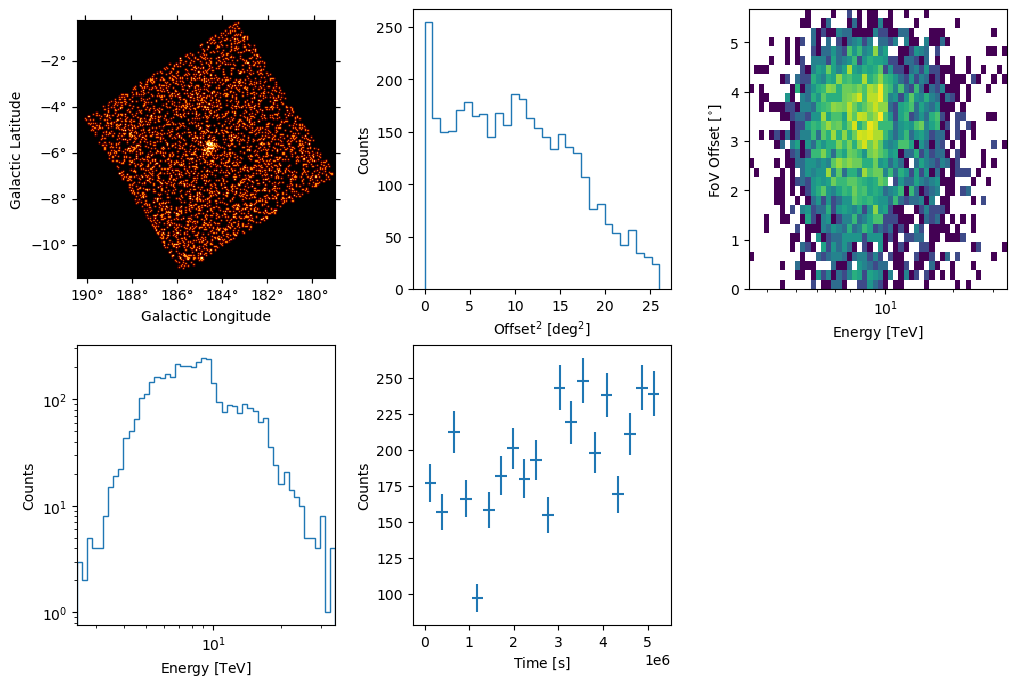

In [24]:
# There is only one observation, and we can check how it looks like
obs = data_store.get_observations()[0]
obs.events.peek()
plt.show()

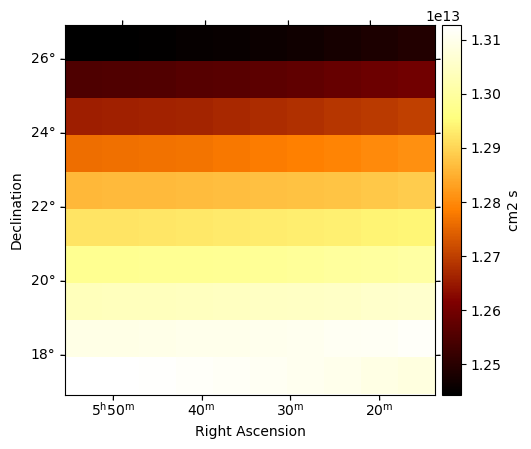

In [25]:
# We can see how the exposure depends mainly on the declination
plt.figure()
obs.aeff.reduce_over_axes().plot(add_cbar=True)
plt.show()

We will now produce a MapDataset using the data from one of the fHit bins. In order to use all bins, one just needs to repeat this process inside a for loop that modifies the variable fHit.

So let's move on and create the geometry and energy axis:

In [26]:
energy_axis = MapAxis.from_edges(
    [1.00, 1.78, 3.16, 5.62, 10.0, 17.8, 31.6, 56.2, 100, 177, 316] * u.TeV,
    name="energy",
    interp="log",
)

energy_axis_true = MapAxis.from_energy_bounds(
    1e-3, 1e4, nbin=140, unit="TeV", name="energy_true"
)

geom = WcsGeom.create(
    skydir=SkyCoord(ra=83.63, dec=22.01, unit="deg", frame="icrs"),
    width=6 * u.deg,
    axes=[energy_axis],
    binsz=0.05,
)

maker = MapDatasetMaker(selection=["counts", "background", "exposure", "edisp", "psf"])
safe_mask_maker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

In [27]:
# And from there we proceed and create our dataset
dataset_empty = MapDataset.create(
    geom, energy_axis_true=energy_axis_true, name=f"fHit {fHit}", reco_psf=True
)
dataset = maker.run(dataset_empty, obs)

The livetime information is used by the SafeMaskMaker to retrieve the effective area from the exposure. The HAWC effective area is computed for one source transit above 45º zenith, which is around 6h. Since the effective area condition used here is relative to the maximum, this value does not actually impact the result.

In [28]:
dataset.exposure.meta["livetime"] = "6 h"
dataset = safe_mask_maker.run(dataset)

Now we have a dataset that has background and exposure quantities for one single transit, but our dataset might comprise more. The number of transits can be derived using the good time intervals (GTI) stored with the event list. For convenience, the HAWC data release already included this quantity as a map, but we need to apply and correct both quantities:

In [29]:
transit_map = Map.read(data_path + "irfs/TransitsMap_Crab.fits.gz")
transit_number = transit_map.get_by_coord(geom.center_skydir)

dataset.background.data *= transit_number
dataset.exposure.data *= transit_number

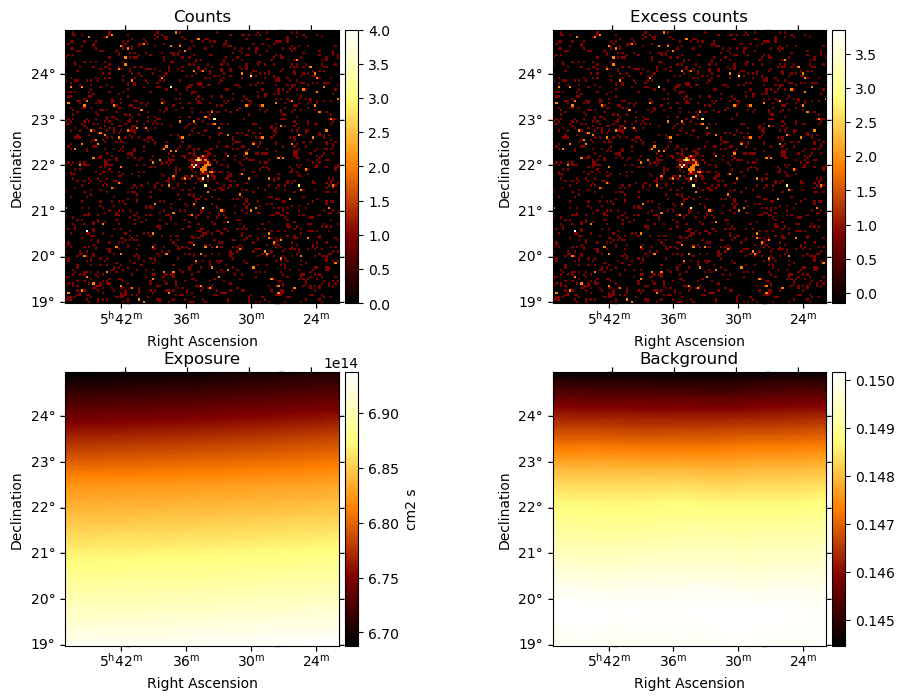

In [30]:
# And see how it looks like

dataset.peek()
plt.show()

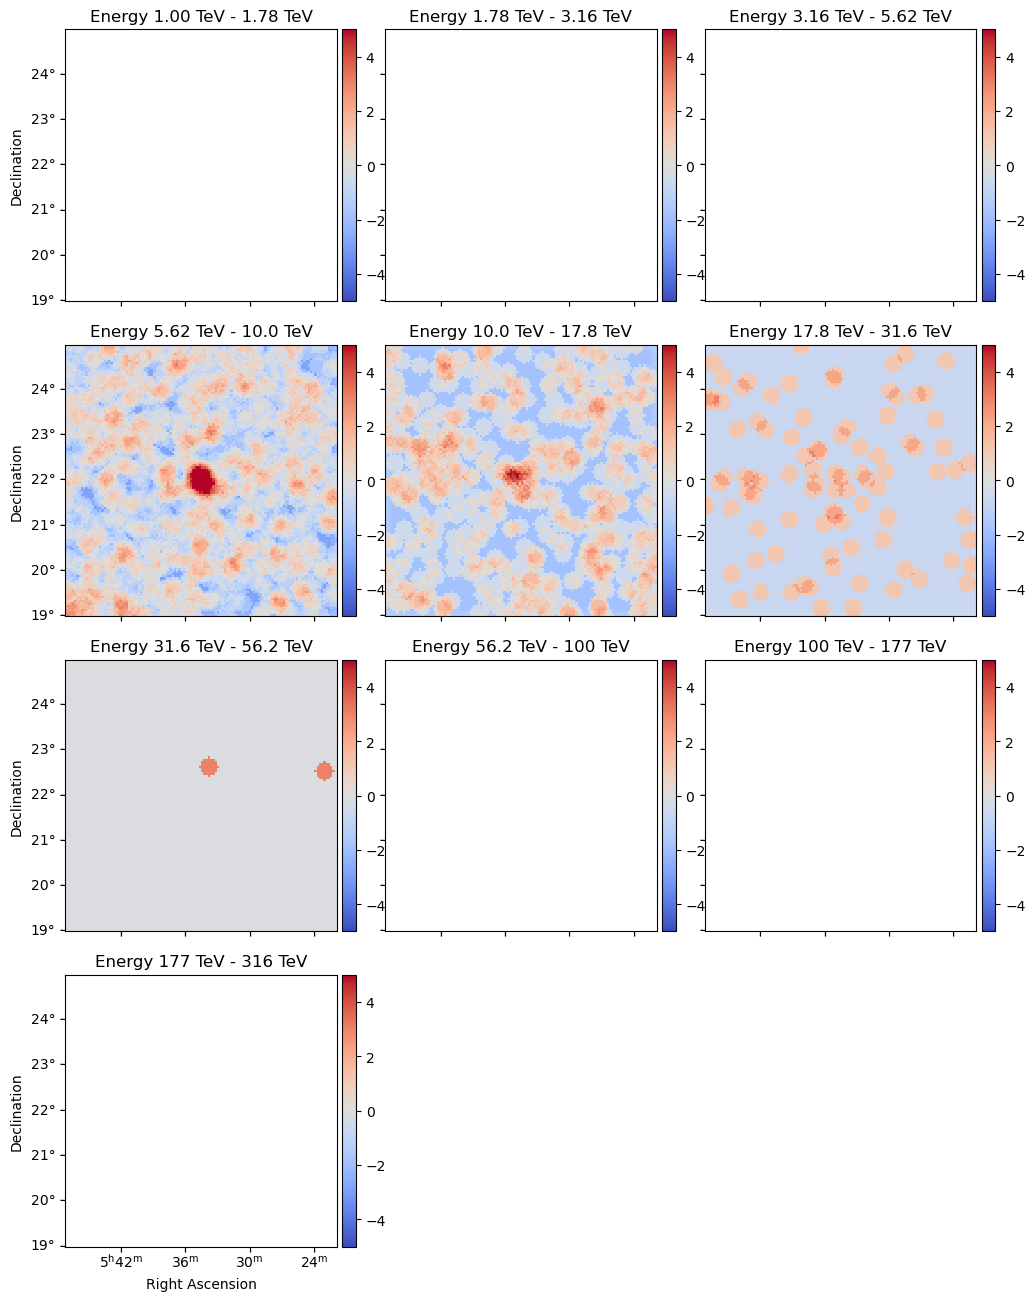

In [31]:
# It seems clear that there is something, but let's see how significant that is
excess_estimator = ExcessMapEstimator(
    correlation_radius="0.2 deg", selection_optional=[], energy_edges=energy_axis.edges
)
excess = excess_estimator.run(dataset)

(dataset.mask * excess["sqrt_ts"]).plot_grid(
    add_cbar=True, cmap="coolwarm", vmin=-5, vmax=5
)
plt.show()


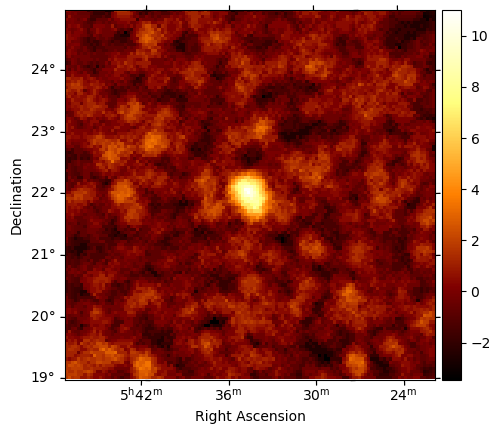

In [32]:
# And combining all energies
excess_estimator_integrated = ExcessMapEstimator(
    correlation_radius="0.2 deg", selection_optional=[]
)
excess_integrated = excess_estimator_integrated.run(dataset)

excess_integrated["sqrt_ts"].plot(add_cbar=True)
plt.show()


*On the comment on light curves and HAWC*:

So basically here, once you have your dataset, you just need to employ the [LighCurveEstimator function](https://docs.gammapy.org/dev/api/gammapy.estimators.LightCurveEstimator.html#gammapy.estimators.LightCurveEstimator). By default these function will use the time intervals of the list of observations. But you can define your own intervales like:

In [131]:
from astropy.time import Time
time_intervals = [
    Time([53343.5, 53344.5], format="mjd", scale="utc"), # This times are just an example
    Time([53345.5, 53346.5], format="mjd", scale="utc"),
    Time([53347.5, 53348.5], format="mjd", scale="utc"),
]

To define states, I'd suggest to use the [Bayesian Block implementation in Astropy](https://docs.astropy.org/en/stable/api/astropy.stats.bayesian_blocks.html) on your resulting light curve. Once you have your final time intervals, you could divide your dataset according to them, which will create a list of observations.

In [ ]:
short_observations = observations.select_time(time_intervals)
# check that observations have been filtered
print(f"Number of observations after time filtering: {len(short_observations)}\n")
print(short_observations[1].gti)

And then you would perform normally your spectral analysis in each state (if you want to combine e.g. low states, you can do a joint fit). You may want to have a look at [this tutorial](https://docs.gammapy.org/dev/tutorials/analysis-time/time_resolved_spectroscopy.html#sphx-glr-tutorials-analysis-time-time-resolved-spectroscopy-py).

#### **Multi-instrument analysis**

**Objective**: Constrain the spectral parameters of the gamma-ray emission from the Crab nebula between 10 GeV and 100 TeV, using a 3D Fermi dataset, a H.E.S.S. reduced spectrum and HAWC flux points.

This tutorial illustrates how to perform a joint modeling and fitting of the Crab Nebula spectrum using different datasets. The spectral parameters are optimized by combining a 3D analysis of Fermi-LAT data, a ON/OFF spectral analysis of H.E.S.S. data, and flux points from HAWC.

We are going to do this with pre-made datasets.

In [33]:
# Setup
from pathlib import Path
from astropy import units as u
import matplotlib.pyplot as plt
from gammapy.datasets import Datasets, FluxPointsDataset, SpectrumDatasetOnOff
from gammapy.estimators import FluxPoints, FluxPointsEstimator
from gammapy.maps import MapAxis
from gammapy.modeling import Fit
from gammapy.modeling.models import Models, create_crab_spectral_model


In [34]:
from gammapy.utils.check import check_tutorials_setup
from gammapy.utils.scripts import make_path

check_tutorials_setup()



System:

	python_executable      : /home/willde/anaconda3/envs/gammapy-sexten/bin/python 
	python_version         : 3.12.11    
	machine                : x86_64     
	system                 : Linux      


Gammapy package:

	version                : 1.3        
	path                   : /home/willde/anaconda3/envs/gammapy-sexten/lib/python3.12/site-packages/gammapy 


Other packages:

	numpy                  : 2.3.0      
	scipy                  : 1.16.0     
	astropy                : 7.1.0      
	regions                : 0.10       
	click                  : 8.2.1      
	yaml                   : 6.0.2      
	IPython                : 9.1.0      
	jupyterlab             : 4.3.4      
	matplotlib             : 3.10.3     
	pandas                 : not installed 
	healpy                 : 1.18.1     
	iminuit                : 2.31.1     
	sherpa                 : not installed 
	naima                  : not installed 
	emcee                  : not installed 
	corner                 : not

For Fermi, we load the dataset and the model (which is based in the 4FGL)


In [35]:
path = Path("$GAMMAPY_DATA/fermi-3fhl-crab")
filename = path / "Fermi-LAT-3FHL_datasets.yaml"

datasets = Datasets.read(filename=filename)

models = Models.read(path / "Fermi-LAT-3FHL_models.yaml")
print(models)

Models

Component 0: SkyModel

  Name                      : Crab Nebula
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   1.82e-02   +/- 3.0e-03 1 / (TeV s cm2)
    reference             (frozen):      0.000       TeV         
    alpha                         :      1.652   +/-    0.06             
    beta                          :      0.039   +/-    0.01             
    lon_0                 (frozen):     83.633       deg         
    lat_0                 (frozen):     22.020       deg         

Component 1: FoVBackgroundModel

  Name                      : Fermi-LAT-bkg
  Datasets names            : ['Fermi-LAT']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                          :      1.300   +/-    0.08             
    tilt                  (frozen):      0.000         

/home/willde/anaconda3/envs/gammapy-sexten/lib/python3.12/site-packages/gammapy/utils/scripts.py:66: UserWarning: Checksum verification failed.
  warnings.warn("Checksum verification failed.", UserWarning)


In [36]:
print(models["Crab Nebula"])


SkyModel

  Name                      : Crab Nebula
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   1.82e-02   +/- 3.0e-03 1 / (TeV s cm2)
    reference             (frozen):      0.000       TeV         
    alpha                         :      1.652   +/-    0.06             
    beta                          :      0.039   +/-    0.01             
    lon_0                 (frozen):     83.633       deg         
    lat_0                 (frozen):     22.020       deg         




Now we will load HESS data

In [37]:
datasets_hess = Datasets()

for obs_id in [23523, 23526]:
    dataset = SpectrumDatasetOnOff.read(
        f"$GAMMAPY_DATA/joint-crab/spectra/hess/pha_obs{obs_id}.fits"
    )
    datasets_hess.append(dataset)

dataset_hess = datasets_hess.stack_reduce(name="HESS")

datasets.append(dataset_hess)

print(datasets)

Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : Fermi-LAT
  Instrument : 
  Models     : 

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : HESS
  Instrument : 
  Models     : 




We have now both datasets, let's load the third one. In the case of HAWC we are going to read them from a file


In [38]:
# read flux points from https://arxiv.org/pdf/1905.12518.pdf
filename = "$GAMMAPY_DATA/hawc_crab/HAWC19_flux_points.fits"
flux_points_hawc = FluxPoints.read(
    filename, reference_model=create_crab_spectral_model("meyer")
)

dataset_hawc = FluxPointsDataset(data=flux_points_hawc, name="HAWC")

datasets.append(dataset_hawc)

# And now we should see the three of them
print(datasets)


Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : Fermi-LAT
  Instrument : 
  Models     : 

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : HESS
  Instrument : 
  Models     : 

Dataset 2: 

  Type       : FluxPointsDataset
  Name       : HAWC
  Instrument : 
  Models     : 




In [39]:
#### Naturally, as in the past, we can save the dataset of the three datasets
path = Path("crab-3datasets")
path.mkdir(exist_ok=True)

filename = path / "crab_10GeV_100TeV_datasets.yaml"

datasets.write(filename, overwrite=True)

datasets = Datasets.read(filename)
datasets.models = models

print(datasets) #Note that the model is going to be unique for all of them

HDU 'MASK_FIT' not found
/home/willde/anaconda3/envs/gammapy-sexten/lib/python3.12/site-packages/gammapy/utils/scripts.py:66: UserWarning: Checksum verification failed.
  warnings.warn("Checksum verification failed.", UserWarning)
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.


Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : Fermi-LAT
  Instrument : 
  Models     : ['Crab Nebula', 'Fermi-LAT-bkg']

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : HESS
  Instrument : 
  Models     : ['Crab Nebula']

Dataset 2: 

  Type       : FluxPointsDataset
  Name       : HAWC
  Instrument : 
  Models     : ['Crab Nebula']




In [40]:
### And we can run the normal fit 
fit_joint = Fit()
results_joint = fit_joint.run(datasets=datasets)
print(results_joint)

HDU 'MASK_FIT' not found


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 313
	total stat : -12697.23

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [41]:
## And see the results
crab_spec = datasets[0].models["Crab Nebula"].spectral_model
print(crab_spec)

LogParabolaSpectralModel

type    name     value         unit        error   min max frozen link prior
---- --------- ---------- -------------- --------- --- --- ------ ---- -----
     amplitude 3.9730e-03 TeV-1 s-1 cm-2 3.122e-04 nan nan  False           
     reference 5.0548e-05            TeV 0.000e+00 nan nan   True           
         alpha 1.2633e+00                1.706e-02 nan nan  False           
          beta 6.1323e-02                9.444e-04 nan nan  False           


In [42]:
# compute Fermi-LAT and H.E.S.S. flux points
energy_edges = MapAxis.from_energy_bounds("10 GeV", "2 TeV", nbin=5).edges

flux_points_fermi = FluxPointsEstimator(
    energy_edges=energy_edges,
    source="Crab Nebula",
).run([datasets["Fermi-LAT"]])


energy_edges = MapAxis.from_bounds(1, 15, nbin=6, interp="log", unit="TeV").edges

flux_points_hess = FluxPointsEstimator(
    energy_edges=energy_edges, source="Crab Nebula", selection_optional=["ul"]
).run([datasets["HESS"]])


And we can finally plot everything together

/home/willde/anaconda3/envs/gammapy-sexten/lib/python3.12/site-packages/gammapy/maps/region/ndmap.py:149: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.errorbar(
/home/willde/anaconda3/envs/gammapy-sexten/lib/python3.12/site-packages/gammapy/maps/region/ndmap.py:149: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.errorbar(


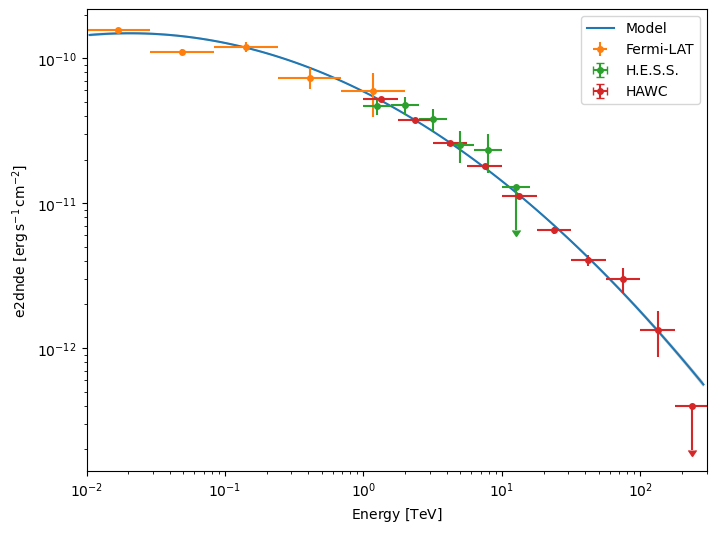

In [43]:
# display spectrum and flux points
fig, ax = plt.subplots(figsize=(8, 6))

energy_bounds = [0.01, 300] * u.TeV
sed_type = "e2dnde"

crab_spec.plot(ax=ax, energy_bounds=energy_bounds, sed_type=sed_type, label="Model")
crab_spec.plot_error(ax=ax, energy_bounds=energy_bounds, sed_type=sed_type)

flux_points_fermi.plot(ax=ax, sed_type=sed_type, label="Fermi-LAT")
flux_points_hess.plot(ax=ax, sed_type=sed_type, label="H.E.S.S.")
flux_points_hawc.plot(ax=ax, sed_type=sed_type, label="HAWC")

ax.set_xlim(energy_bounds)
ax.legend()
plt.show()

*Exercise: The spectrum looks decent, but could it be well reproduced by a power-law with an exponential cut-off? How would you test that? And beyond that, is the spatial part well fitted?*

#### **Beyond standard analysis: Testing your models**

At the end, you also want to test your own models. We already saw how to add your own templates (you could also fit other spatial shapes). How do we do that with spectral ones?

We saw that multiplying you can combine spectra. You can also create your own class:


In [44]:
from gammapy.modeling import Parameter
from gammapy.modeling.models import SpectralModel
import numpy as np


class MyCustomSpectralModel(SpectralModel):
    """My custom spectral model, parametrizing a power law plus a Gaussian spectral line.

    Parameters
    ----------
    amplitude : `astropy.units.Quantity`
        Amplitude of the spectra model.
    index : `astropy.units.Quantity`
        Spectral index of the model.
    reference : `astropy.units.Quantity`
        Reference energy of the power law.
    mean : `astropy.units.Quantity`
        Mean value of the Gaussian.
    width : `astropy.units.Quantity`
        Sigma width of the Gaussian line.

    """

    tag = "MyCustomSpectralModel"
    amplitude = Parameter("amplitude", "1e-12 cm-2 s-1 TeV-1", min=0)
    index = Parameter("index", 2, min=0)
    reference = Parameter("reference", "1 TeV", frozen=True)
    mean = Parameter("mean", "1 TeV", min=0)
    width = Parameter("width", "0.1 TeV", min=0, frozen=True)

    @staticmethod
    def evaluate(energy, index, amplitude, reference, mean, width):
        pwl = PowerLawSpectralModel.evaluate(
            energy=energy,
            index=index,
            amplitude=amplitude,
            reference=reference,
        )
        gauss = amplitude * np.exp(-((energy - mean) ** 2) / (2 * width**2))
        return pwl + gauss


MyCustomSpectralModel

type    name     value         unit        error   ... max frozen link prior
---- --------- ---------- -------------- --------- ... --- ------ ---- -----
     amplitude 1.0000e-12 TeV-1 s-1 cm-2 0.000e+00 ... nan  False           
         index 2.0000e+00                0.000e+00 ... nan  False           
     reference 1.0000e+00            TeV 0.000e+00 ... nan   True           
          mean 3.0000e+00            TeV 0.000e+00 ... nan  False           
         width 1.0000e-01            TeV 0.000e+00 ... nan   True           
1.1442739329466746e-12 1 / (s cm2)


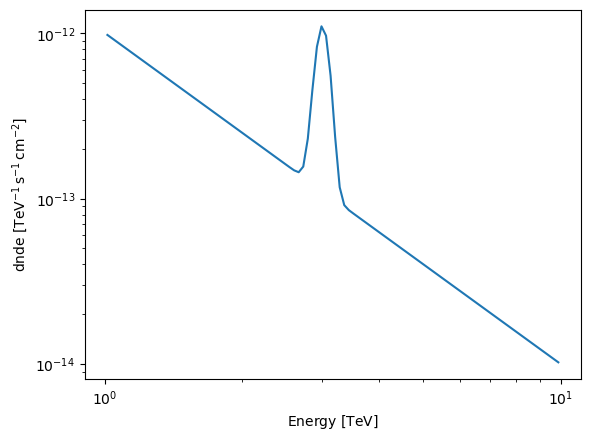

In [45]:
my_custom_model = MyCustomSpectralModel(mean="3 TeV")
print(my_custom_model)

print(my_custom_model.integral(1 * u.TeV, 10 * u.TeV))

my_custom_model.plot(energy_bounds=[1, 10] * u.TeV)
plt.show()

Alternatively, you can provide tabulated values, from your output from JetSet, Naima, or your preferred code

PowerLawNormSpectralModel

type    name     value    unit   error   min max frozen link prior
---- --------- ---------- ---- --------- --- --- ------ ---- -----
          norm 5.0000e-01      0.000e+00 nan nan  False           
          tilt 0.0000e+00      0.000e+00 nan nan   True           
     reference 1.0000e+00  TeV 0.000e+00 nan nan   True           


/home/willde/anaconda3/envs/gammapy-sexten/lib/python3.12/site-packages/gammapy/modeling/models/spectral.py:482: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(energy.center, flux.quantity[:, 0, 0], **kwargs)


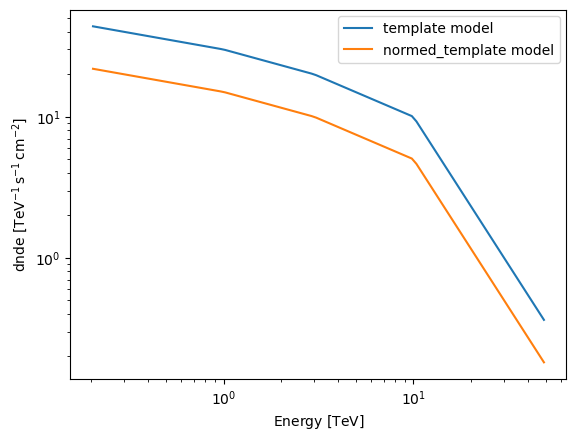

In [46]:
from gammapy.modeling.models import TemplateSpectralModel
from gammapy.modeling.models import PowerLawNormSpectralModel

pwl_norm = PowerLawNormSpectralModel(tilt=0.0, norm=0.5) # Tilt sets an energy dependence in the normalization
print(pwl_norm)

energy = [0.3, 1, 3, 10, 30] * u.TeV
values = [40, 30, 20, 10, 1] * u.Unit("TeV-1 s-1 cm-2")
template = TemplateSpectralModel(energy, values)
template.plot(energy_bounds=[0.2, 50] * u.TeV, label="template model")
normed_template = template * pwl_norm
normed_template.plot(energy_bounds=[0.2, 50] * u.TeV, label="normed_template model")
plt.legend()
plt.show()


And, finally, how do you extract the likelihood value? Very simple:


In [47]:
print('Log-likelihood: ', results_joint.total_stat)

Log-likelihood:  -12697.23003885904


So from there you could scan the parameters and derive likelihood profiles ([see also the scan functions in gammapy](https://docs.gammapy.org/dev/tutorials/api/fitting.html)), or convert it to AIC, BIC, or whatever you prefer.

*Note on likelihood profiles:* 

$2\Delta (log L) = 2.706$ -> 95% Upper limit / 90% error (sometimes referred to as $\Delta TS$)

**Detection**

![workflow](EBL_likelihood.png)

**Upper limits**

![workflow](Upper_limits.png)